In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

#for model creation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import SGD

#for saving/importing models
from keras.models import load_model
from pickle import dump, load

#for NLP preprocessing
from nltk.corpus import stopwords
import nltk

#Preprocessing and Data Exploration

In [ ]:
df = pd.read_csv('train_original_new_column.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,final_toxicity
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
df.shape

(159571, 9)

In [ ]:
#unbalanced
print('--Unbalanced--')
print("Non-toxic: ", len(df[df['final_toxicity'] == 0]) / len(df))
print("Toxic: ", len(df[df['final_toxicity'] == 1]) / len(df))

--Unbalanced--
Non-toxic:  0.8983211235124177
Toxic:  0.10167887648758234


In [ ]:
# ---- Balancing ----

# undersample majority class (i.e. toxic)
x = len(df[df['final_toxicity'] == 1])
resampled_majority = df[df['final_toxicity'] == 0].sample(x, random_state=42)

#combine resampled majority with minority class rows
balanced_df = df[df['final_toxicity'] == 1].append(resampled_majority)

print('--Balanced--')
print("Non-toxic: ", len(balanced_df[balanced_df['final_toxicity'] == 0]) / len(balanced_df))
print("Toxic: ", len(balanced_df[balanced_df['final_toxicity'] == 1]) / len(balanced_df))
balanced_df.shape


--Balanced--
Non-toxic:  0.5
Toxic:  0.5


(32450, 9)

In [ ]:
def preprocess(df):
  
    '''Note: This function mutates the original dataframe'''

    
    # Lowercase letters
    df['comment_text'] = df['comment_text'].str.lower()
    
    # Remove special characters (e.g. @, $, %)
    df['comment_text'] = df['comment_text'].str.replace("[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", " ") 
    
    # # Remove specific punctuations - keeps quotes
    df['comment_text'] = df['comment_text'].str.replace('[^\w\s\'\"]', "")
    
    # Remove random numbers
    df['comment_text'] = df['comment_text'].str.replace("[^a-z' ]", "")
    
    # Remove repeating characters and extra spaces 
    # Examples: 'whaaat' --> 'what' OR 'hello   bye' --> 'hello bye'
    # Note: This does change words like "look" to "lok" cuz of the double letters, 
    # if we don't want this, we can remove the \w in the regex pattern below.
    repeat_pattern = re.compile(r'(\s)\1*')
    match_substitution = r'\1'
    df['comment_text'] = df['comment_text'].apply(lambda x: repeat_pattern.sub(match_substitution, x))
    
    return df

In [ ]:
df_clean = preprocess(balanced_df)
df_clean.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,final_toxicity
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,1
12,0005c987bdfc9d4b,hey what is it talk what is it an exclusive gr...,1,0,0,0,0,0,1
16,0007e25b2121310b,bye don't look come or think of comming back t...,1,0,0,0,0,0,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1,0,1,0,1,0,1


In [ ]:
print("Average length of sentences: ", np.mean(df_clean['comment_text'].apply(lambda x: len(x.split(' ')))))
print("Median length of sentences: ", np.median(df_clean['comment_text'].apply(lambda x: len(x.split(' ')))))

Average length of sentences:  60.50446841294299
Median length of sentences:  29.0


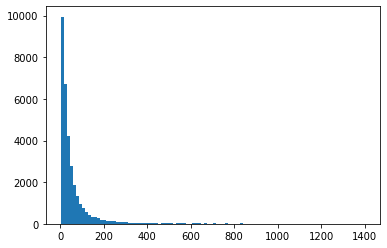

In [ ]:
plt.hist(df_clean['comment_text'].apply(lambda x: len(x.split(' '))).values, bins=100);

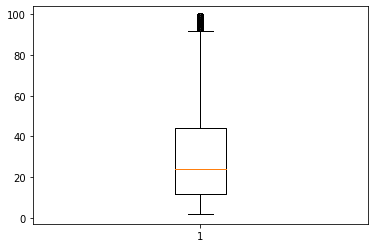

In [ ]:
# other than outliers (as seen in histogram above), most comments are around 20-40 in word length

plt.boxplot(df_clean['comment_text'].apply(lambda x: len(x.split(' '))).values[df_clean['comment_text'].apply(lambda x: len(x.split(' '))).values < 100]);

In [ ]:
vocab_size = 5000
embedding_dim = 20
max_length = 20
trunc_type = 'post' # trim at the end
padding_type = 'post' # add 0's at the end
oov_tok = '<OOV>' # placeholder character for unseen words
training_portion = 0.9

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#split labels and sentences (while also removing stop words from sentences)

sentences = []
labels = []

for index, row in df_clean.iterrows():
    labels.append(row['final_toxicity'])
    sentence = row['comment_text']
    for word in STOPWORDS: #remove stopwords from sentence
        token = ' ' + word + ' '
        sentence = sentence.replace(token, ' ')
        sentence = sentence.replace(' ', ' ')
    sentences.append(sentence)


sentences = np.array(sentences)
labels = np.array(labels)

#sanity check that lengths are the same
print(len(labels))
print(len(sentences))

32450
32450


In [ ]:
#simple train-test split
np.random.seed(42) 
n = len(sentences)

train_size = int(n * training_portion)
train_indices = np.random.choice(n, size=train_size, replace=False)
test_indices = np.arange(n)[~np.isin(np.arange(n), train_indices)]

x_train = sentences[train_indices]
y_train = labels[train_indices]

x_validation = sentences[test_indices]
y_validation = labels[test_indices]


print('Size: ', train_size)
print()

print('--Train--')
print(len(x_train))
print(len(y_train))
print()
print('--Test--')
print(len(x_validation))
print(len(y_validation))

Size:  29205

--Train--
29205
29205

--Test--
3245
3245


In [ ]:
# tokenize the words 
# Tokenizer from Tensorflow will take the 5000 most common words (vocab_size value set in parameters above)
# and if a word is not in this list, we put in <OOV> to indicate an unseen word was encountered in text

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) #create tokenizer
tokenizer.fit_on_texts(x_train) #tokenize fit on x_train
word_index = tokenizer.word_index # word_index = each word has been tokenized and mapped to a number value

In [ ]:
dict(list(word_index.items())[0:10]) # dictionary of {word : number value}

{'<OOV>': 1,
 'article': 3,
 'fuck': 2,
 'like': 6,
 'one': 8,
 'page': 5,
 'please': 10,
 'talk': 7,
 'wikipedia': 4,
 'would': 9}

In [ ]:
# turn tokens into list of sequences 

# map each sentence into numbers/tokens based on the word_index
train_sequences = tokenizer.texts_to_sequences(x_train)

In [ ]:
# example: 
print('Original Text: ', x_train[-1])
print('Tokenized Text: ', train_sequences[-1]) 

# check size length (sanity check - note: tokenized might have less cuz we removed stop words)
print()
print('Original length: ', len(x_train[-1].split(' ')))
print('Tokenized length: ', len(train_sequences[-1]))

Original Text:  sean hoyland moron lead says terrorist attack thats attack embassy would usually classified next section describes kind attack car bomb sean hoyland moron
Tokenized Text:  [4247, 1, 41, 564, 241, 1771, 246, 722, 246, 1, 9, 928, 3522, 420, 86, 2897, 292, 246, 2247, 3800, 4247, 1, 41]

Original length:  23
Tokenized length:  23


In [ ]:
# we need sequences to be the same size in a NLP neural network, so we'll pad and trim our tokenized sequences
# current hyperparam = 200 max length

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# sanity check that padding worked
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

5
20
7
20
11
20


In [ ]:
# do the same preprocessing (i.e. tokenization) that we just did above to the validation set
validation_sequences = tokenizer.texts_to_sequences(x_validation)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# confirm that the size and shape are the same as before (i.e. when we had split the data)
print(len(validation_sequences))
print(validation_padded.shape)

3245
(3245, 20)


In [ ]:
# our labels are already in numerical form, so we don't need to tokenize them
# 0: non-toxic
# 1: toxic

# our labels are expected to be in numpy array form
training_label_seq = np.array(y_train)
validation_label_seq = np.array(y_validation)

# sanity check for labels and shape
print(set(labels))
print(training_label_seq.shape)
print(validation_label_seq.shape)

{0, 1}
(29205,)
(3245,)


In [ ]:
# let's review our preprocessed data/sentences

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_article(train_padded[100]))
print('---')
print(x_train[100])

#notice OOV is used to supplement/serve as a placeholder for unknown words/vocab

<OOV> spent enough time wikipedia disambiguation pages become <OOV> vast number terms also names rock bands long suspected article <OOV>
---
having spent enough time wikipedia disambiguation pages become acquainted vast number terms also names rock bands long suspected article confirms everything also band 


#Creating Model and Validating

In [ ]:
embedding_dim

20

In [ ]:
# Creating our recurrent neural network model


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(60)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()

#compile
model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['accuracy'])

num_epochs = 15
batch_size = 100
#fit
history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs = num_epochs, 
                    batch_size = batch_size,
                    validation_data = (validation_padded, validation_label_seq), 
                    verbose = 1)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, None, 20)          100000    
_________________________________________________________________
dropout_103 (Dropout)        (None, None, 20)          0         
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 120)               38880     
_________________________________________________________________
dropout_104 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 64)                7744      
_________________________________________________________________
dropout_105 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 2)               

In [ ]:
# #save the model 
# model.save('model.h5')
# print('Saved model to disk!')

In [ ]:
# #save token mapping 
# dump(word_index, open('mapping.pkl', 'wb'))
# print('Saved tokenizer mapping to disk!')

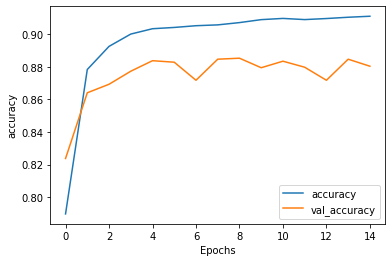

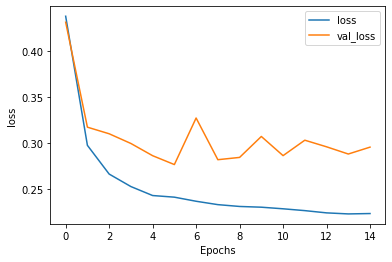

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# predict on something random (TODO: need to preprocess this the same way, create some functions)
txt = ["Your vandalism to the Matt Shirvington article has been reverted."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = [0, 1]
print(pred, labels[np.argmax(pred)])

[[0.9953282 0.1460363]] 0


In [ ]:

txt = ["you suck"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = [0, 1]
print(pred, labels[np.argmax(pred)])

[[0.01067209 1.        ]] 1


In [ ]:
# Note: too much padding can lead to worse results cuz 
# bad content/words can be obscured by filler padding
padded 

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 27, 20]], dtype=int32)

#Predictions on Test Set

In [ ]:
# # load model
# model_loaded = load_model('model.h5')
# # summarize model.
# model_loaded.summary()

In [ ]:
# # load the mapping
# tokenizer = load(open('mapping.pkl', 'rb'))

In [ ]:
test = pd.read_csv("test_filtered.csv")
test.head()

,id,comment_text
0,0001ea8717f6de06,Thank you for understanding. I think very high...
1,000247e83dcc1211,:Dear god this site is horrible.
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [ ]:
#preprocess the same way as training set
preprocess(test)
test.head()

,id,comment_text
0,0001ea8717f6de06,thank you for understanding i think very highl...
1,000247e83dcc1211,dear god this site is horrible
2,0002f87b16116a7f,somebody will invariably try to add religion ...
3,0003e1cccfd5a40a,it says it right there that it is a type the ...
4,00059ace3e3e9a53,before adding a new product to the list make ...


In [ ]:
test.shape

(63978, 2)

In [ ]:
def classify(sentence):
  seq = tokenizer.texts_to_sequences(sentence)
  padded = pad_sequences(seq, maxlen=max_length)
  pred = model.predict(padded) #probabilities
  labels = [0, 1]
  return labels[np.argmax(pred)] #max probability 

In [ ]:
# txt = ['hello']
# seq = tokenizer['hello']
# padded = pad_sequences(seq, maxlen=max_length)
# pred = model.predict(padded) #probabilities
# labels = [0, 1]
# labels[np.argmax(pred)]



In [ ]:
test['predictions'] = test[['comment_text']].apply(classify, axis=1) #took a while, probably because there's so many rows

In [ ]:
test

,id,comment_text,predictions
0,0001ea8717f6de06,thank you for understanding i think very highl...,0
1,000247e83dcc1211,dear god this site is horrible,0
2,0002f87b16116a7f,somebody will invariably try to add religion ...,0
3,0003e1cccfd5a40a,it says it right there that it is a type the ...,0
4,00059ace3e3e9a53,before adding a new product to the list make ...,0
...,...,...,...
63973,fff8f64043129fa2,jerome i see you never got around to this i m...,0
63974,fff9d70fe0722906,lucky bastard http wikimediafoundationorg wik...,1
63975,fffa8a11c4378854,shame on you all you want to speak about gays...,1
63976,fffac2a094c8e0e2,mel gibson is a nazi bitch who makes shitty mo...,1


In [ ]:
test.to_csv("samantha_predictions2.csv", index=False)

In [ ]:
test_labels = pd.read_csv('test_labels_new_column.csv')
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,final_toxicity
0,0001ea8717f6de06,0,0,0,0,0,0,0
1,000247e83dcc1211,0,0,0,0,0,0,0
2,0002f87b16116a7f,0,0,0,0,0,0,0
3,0003e1cccfd5a40a,0,0,0,0,0,0,0
4,00059ace3e3e9a53,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,0,0,0,0,0,0,0
63974,fff9d70fe0722906,0,0,0,0,0,0,0
63975,fffa8a11c4378854,0,0,0,0,0,0,0
63976,fffac2a094c8e0e2,1,0,1,0,1,0,1


In [ ]:
from sklearn.metrics import confusion_matrix

y_true = test_labels['final_toxicity']
y_pred = test['predictions']

confusion_matrix(y_true, y_pred)

# ----------
#| TN | FP |
# ----------
#| FN | TP |
# ----------

array([[48819,  8916],
       [  851,  5392]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(48819, 8916, 851, 5392)

In [ ]:
# precision (P):   TP/ (TP + FP)
# recall (R):      TP/ (TP + FN)
# f1 score:        2 * (P * R / (P + R))
# accuracy:        (TN + TP) / (TN + TP + FP + FN)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = (tn + tp)/ (tn + fp + fn + tp)

print("Precision: ", precision)
print('Recall: ', recall)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.37685211070729663
Recall:  0.8636873298093866
F1 Score:  0.5247433214928714
Accuracy:  0.847338147488199
